In [4]:

from ucimlrepo import fetch_ucirepo

polish_companies_bankruptcy = fetch_ucirepo(id=365)

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [10]:
type(polish_companies_bankruptcy)

ucimlrepo.dotdict.dotdict

In [16]:
polish_companies_bankruptcy.keys()

dict_keys(['data', 'metadata', 'variables'])

In [20]:
df = polish_companies_bankruptcy.data.features
target = polish_companies_bankruptcy.data.targets

In [21]:
df = pd.concat([df,target],axis=1)
df.shape

(43405, 66)

class
0    0.951826
1    0.048174
Name: proportion, dtype: float64


Text(0.5, 1.0, 'class balance')

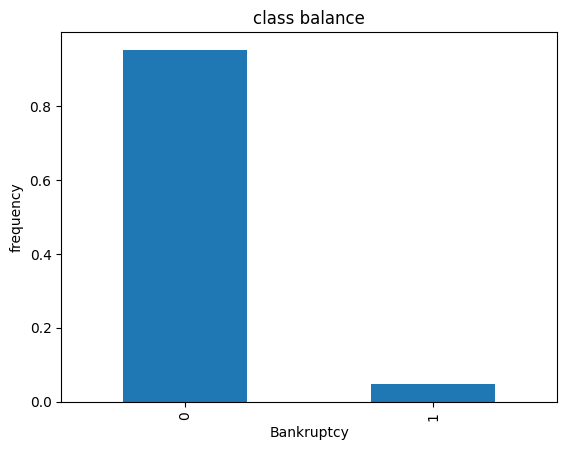

In [24]:
# class balance 
print(df["class"].value_counts(normalize = True))
df["class"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Bankruptcy")
plt.ylabel("frequency")
plt.title("class balance")

# positive class - bankruptcy = true - 1 - minority class
# negative class - bankruptcy = no - 0 - majority class

Text(0, 0.5, 'profit/expense')

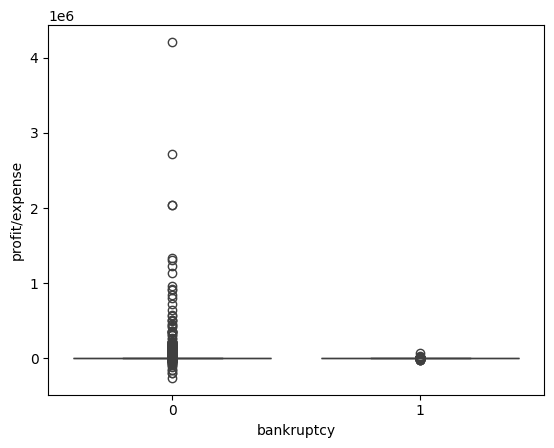

In [25]:
# side by side boxplot for bankruptcy and A27(profit by expense)
sns.boxplot(x = "class", y = "A27", data =  df)
plt.xlabel("bankruptcy")
plt.ylabel("profit/expense")

In [26]:
# A27 describe (mean, std)
df["A27"].describe().apply("{0:,.0f}".format)

count       40,641
mean         1,108
std         35,015
min       -259,000
25%              0
50%              1
75%              5
max      4,210,000
Name: A27, dtype: object

In [28]:
# assign feature and target
X = df.drop(columns =["class"])
y = df["class"]
print(X.shape)
y.shape

(43405, 65)


(43405,)

In [29]:
# splitting
# training data = 80% and testing data = 20%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(34724, 65)
(34724,)
(8681, 65)
(8681,)


In [30]:
# oversamling adding extra(duplicate) samples
over_sample = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sample.fit_resample(X_train,y_train)

print(X_train_over.shape)

print(y_train_over.shape)

(66148, 65)
(66148,)


In [40]:
acc_baseline = df["class"].value_counts(normalize=True).max()
acc_baseline

0.9518258265176823

In [44]:
#building the model
clf = make_pipeline(SimpleImputer(strategy = "median"),RandomForestClassifier(random_state = 42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [46]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv = 5, n_jobs = -1)

In [47]:
print(cv_acc_scores)

[0.99818594 0.99818594 0.99690098 0.99841258 0.99637161]


In [49]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [53]:
# Grid search
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [54]:
#Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [57]:
cv_result = pd.DataFrame(model.cv_results_)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,162.686955,3.324899,0.967311,0.262522,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.949584,0.950340,0.951550,0.952151,0.944440,0.949613,0.002738,21
1,171.913788,3.716376,0.641890,0.224039,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.942555,0.942479,0.948224,0.943836,0.943382,0.944095,0.002126,24
2,381.246678,8.987559,0.895424,0.251690,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.951247,0.951398,0.953817,0.948976,0.944062,0.949900,0.003297,20
3,388.103065,1.995811,1.211161,0.392039,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.944898,0.942404,0.947770,0.943004,0.946557,0.944927,0.002040,23
4,538.008460,11.946707,1.581822,0.505991,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.953212,0.952532,0.953061,0.949203,0.947615,0.951125,0.002285,19


In [58]:
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'mean'}

In [60]:
model.best_score_

0.9977172428676159

In [61]:
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=75,
                                        random_state=42))])

In [62]:
acc_train = model.score(X_train, y_train)


In [63]:
acc_train

1.0

In [64]:
acc_test = model.score(X_test, y_test)
acc_test

0.9668240986061514

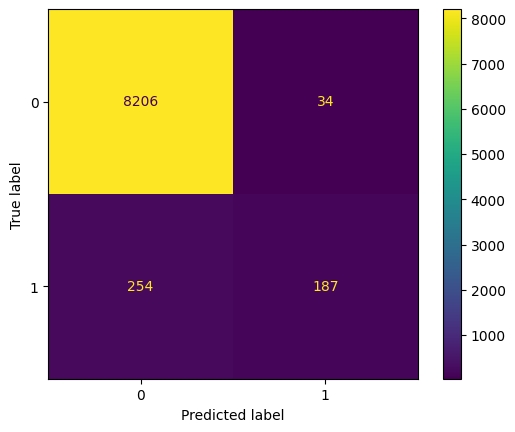

In [66]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

Text(0.5, 1.0, 'model_feature_imp')

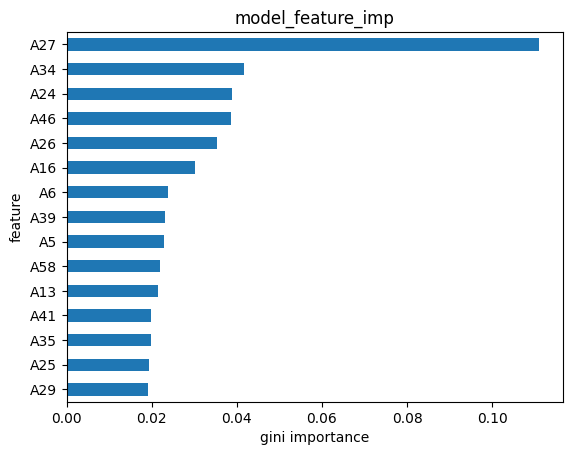

In [74]:
importance = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
feature_imp = pd.Series(importance, index= X_train.columns).sort_values()
# plot
feature_imp.tail(15).plot(kind = "barh")
plt.xlabel("gini importance")
plt.ylabel("feature")
plt.title("model_feature_imp")